# 1. Download dataset from kaggle

In [1]:
! pip install -q kaggle
! echo -n '{"username":"huyennguyenthanh","key":"a41ba555a089314f69cf9d9f27da6f8c"}' >> kaggle.json

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
 ! kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:05<00:00, 219MB/s]
100% 1.04G/1.04G [00:05<00:00, 207MB/s]


In [ ]:
! mkdir train
! unzip flickr8k.zip -d train

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from numpy import array

In [7]:
df = pd.read_csv("/content/train/captions.txt")
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [ ]:
train, val = np.split(df.sample( frac=1,random_state=42), [int(.8*len(df)),])
print(len(df), train.shape, val.shape)

40455 (32364, 2) (8091, 2)


In [9]:
image_path = '/content/train/Images/'

85    A couple and an infant , being held by the mal...
86    A couple sit on the grass with a baby and stro...
87    A couple with their newborn baby sitting under...
88    A man and woman care for an infant along the s...
89    Couple with a baby sit outdoors next to their ...
Name: caption, dtype: object


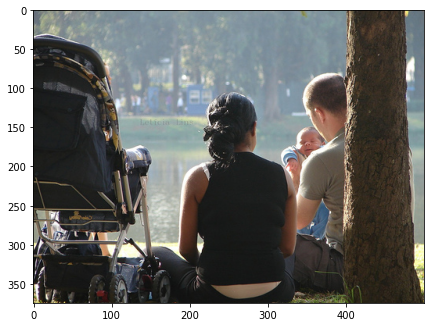

In [15]:
n = 17
img = Image.open(image_path + df['image'][5*n])
plt.figure(figsize=(7, 7))
plt.imshow(img)
print(df['caption'][5*n:5*n+5])

In [ ]:
for i in range(5):
  img = Image.open(image_path + df['image'][i])
  print(img.size)

(375, 500)
(375, 500)
(375, 500)
(375, 500)
(375, 500)


# 2. Preprocessing captions

In [ ]:
import re
def caption_preprocessing(text, remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)
  # tokenize
  text=text.split()
  # convert to lower case
  text = [word.lower() for word in text]
  # remove hanging 's' and 'a'
  # text = [word for word in text if len(word)>1]
  
  # remove tokens with numbers in them
  text = [word for word in text if word.isalpha()]
  # store as string
  text =  ' '.join(text)

  # insert 'startseq', 'endseq' cho chuỗi
  text = 'startseq ' + text + ' endseq'
  return text

print(caption_preprocessing('chao .. ban $ hello980 it\'s a table.#'))

startseq chao ban its a table endseq


In [ ]:
df['caption'] = df['caption'].apply(caption_preprocessing)

In [ ]:
df['caption']

0        startseq a child in a pink dress is climbing u...
1        startseq a girl going into a wooden building e...
2        startseq a little girl climbing into a wooden ...
3        startseq a little girl climbing the stairs to ...
4        startseq a little girl in a pink dress going i...
                               ...                        
40450    startseq a man in a pink shirt climbs a rock f...
40451    startseq a man is rock climbing high in the ai...
40452    startseq a person in a red shirt climbing up a...
40453        startseq a rock climber in a red shirt endseq
40454    startseq a rock climber practices on a rock cl...
Name: caption, Length: 40455, dtype: object

### Count the number of worrds in dataset and max_length of captions

In [ ]:
word_counts = {}
max_length = 0
for text in df['caption']:
  words = text.split()
  max_length = len(words) if (max_length < len(words)) else max_length
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1
print(len(word_counts))
print(max_length)

8777
37


In [ ]:
# Chỉ lấy các từ xuất hiện trên 10 lần
word_count_threshold = 10
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 8777 -> 1952


In [ ]:
i2w = {}
w2i = {}

id = 1
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1

print(len(i2w), len(w2i))
print(i2w[300])

1952 1952
setting


# Embedding word using Glove

In [ ]:
! wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-06-30 09:27:14--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-30 09:27:15--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.14MB/s    in 2m 40s  

2021-06-30 09:29:55 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
! mkdir glove
! unzip glove.6B.zip -d glove

Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


In [ ]:
glove_dir = '/content/glove/'
embeddings_index = {} # empty dictionary
file = open(glove_dir + 'glove.6B.200d.txt', encoding="utf-8")

for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['girl'].shape

(200,)

In [ ]:
embedding_dim = 200
vocab_size = len(vocab) + 1 # thêm 1 padding

In [ ]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in w2i.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(1953, 200)


In [ ]:
from pickle import dump, load

In [ ]:

with open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/embedding_matrix.pkl", "wb") as file:
    dump(embedding_matrix, file)

In [ ]:
embedding_matrix = load(open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/embedding_matrix.pkl", "rb"))
embedding_matrix.shape

(1953, 200)

# Transfer learning on images, using Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3()

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.models import Model
# Tạo model mới, bỏ layer cuối từ inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
model_new.input_shape

(None, 299, 299, 3)

In [ ]:
images = {}
captions = {}

start = time()
for i in range(len(df)):
   images[df['image'][i]] = np.array(Image.open(image_path + df['image'][i]))
  try:
    captions[df['image'][i]].append(df['caption'][i])
  except:
    captions[df['image'][i]] = [df['caption'][i]]
  
print(len(images), len(captions))
print('Time: ',time() - start)

8091 8091
Time:  174.50548434257507


In [ ]:
with open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/encoded_captions.pkl", "wb") as file:
    dump(captions, file)

In [ ]:
captions = load(open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/encoded_captions.pkl", "rb"))
len(captions)

8091

In [ ]:
images[df['image'][0]].shape

(500, 375, 3)

In [ ]:
tmp = np.array([[0,2,1],[3,5,6]])
tmp = np.expand_dims(tmp, axis=0)
tmp

array([[[0, 2, 1],
        [3, 5, 6]]])

In [ ]:
from keras.applications.inception_v3 import preprocess_input
# Image embedding thành vector (2048, )
def encode(image):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = np.resize(image, (299, 299, 3 ))
    # Add one more dimension
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = preprocess_input(img)

    fea_vec = model_new.predict(img) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Gọi hàm encode với các ảnh trong traning set
start = time()
encoding_image = {}
for id, img in images.items():
    encoding_image[id] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 478.9260160923004


In [ ]:
encoding_image['2089542487_b4c1ee7025.jpg'].shape

(2048,)

In [ ]:
train_features = encoding_image

In [ ]:
from pickle import dump, load
with open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/encoded_train_images.pkl", "wb") as file:
    dump(encoding_image, file)

In [ ]:
train_features = load(open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/encoded_train_images.pkl", "rb"))
len(train_features)

8091

# Training

In [ ]:
model = "a"

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(captions, images, w2i, max_length, batch_size):

  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for id, caps in captions.items():
      n += 1
      image = images[id]
      for cap in caps:
        # encode the sequence
        seq = [w2i[word] for word in cap.split(' ') if word in w2i]

        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          
          # store
          X_image.append(image)
          X_cap.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        yield ([np.array(X_image), np.array(X_cap)], np.array(y))
        X_image, X_cap, y = [], [], []
        n = 0


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Input
from tensorflow.keras import optimizers

In [ ]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# max_length = 35, vocab_size = 2005, embedding_dim = 200
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)


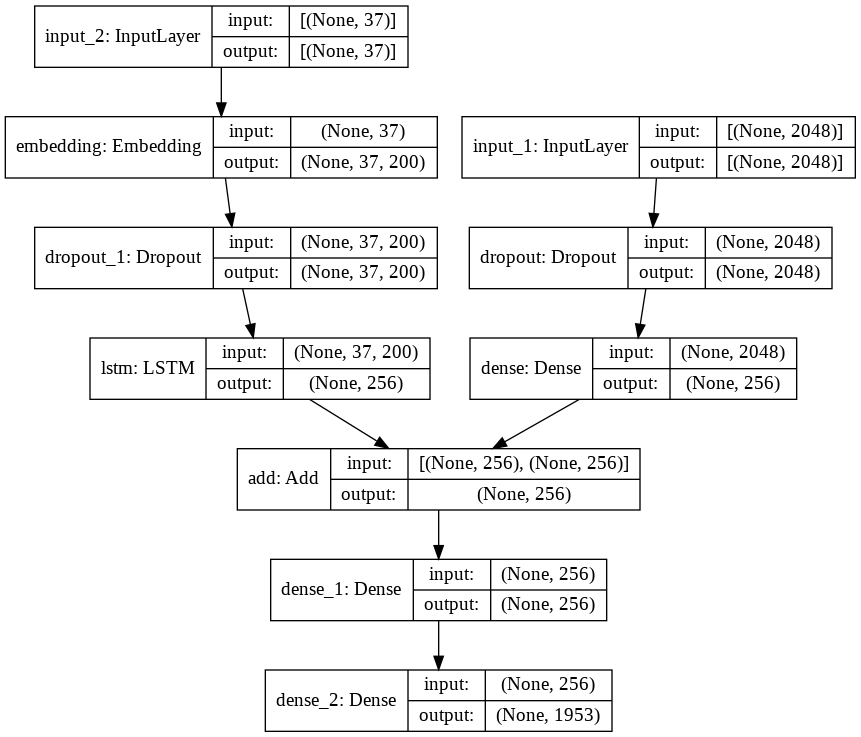

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 200)      390600      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 5
batch_size = 16
steps = len(train_features)

In [ ]:
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/Image Captioning/cp.ckpt"

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only=False, save_weights_only=True, verbose=1)

In [ ]:
generator = data_generator(captions=captions, images=train_features, w2i=w2i, max_length=max_length, batch_size=batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

Epoch 1/5
8091/8091 [==============================] - 1055s 130ms/step - loss: 3.3241
Epoch 2/5
8091/8091 [==============================] - 1038s 128ms/step - loss: 2.9998
Epoch 3/5
8091/8091 [==============================] - 1041s 129ms/step - loss: 2.8467
Epoch 4/5
8091/8091 [==============================] - 1039s 128ms/step - loss: 2.7386
Epoch 5/5
8091/8091 [==============================] - 1034s 128ms/step - loss: 2.6541
Epoch 1/5
1363/8091 [====>.........................] - ETA: 14:20 - loss: 2.6091

KeyboardInterrupt: ignored

In [ ]:
model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

8091/8091 [==============================] - 1036s 128ms/step - loss: 2.5694


In [ ]:
model.save_weights('content/gdrive/My Drive/Colab Notebooks/Image Captioning/model.h5')

In [ ]:
model.save('content/gdrive/My Drive/Colab Notebooks/Image Captioning/model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Load model and inference 

In [ ]:
from tensorflow.keras.models import load_model
model_new = load_model('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/model.h5')


In [ ]:
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 200)      390600      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_new.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

250    startseq a black and white dog is attempting t...
251    startseq a black and white dog jumps after a y...
252    startseq a black and white dog jumps to get th...
253    startseq a black dog is jumping up to catch a ...
254           startseq a dog jumps to catch a toy endseq
Name: caption, dtype: object


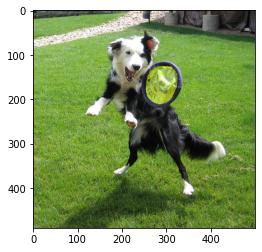

a dog runs through the grass


In [ ]:
pic = list(train_features.keys())[50]
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + pic)
print(df['caption'][df['image'] == pic])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print(predict)

In [ ]:
pic

'1110208841_5bb6806afe.jpg'

30    startseq a black and white dog is running in a...
31    startseq a black and white dog is running thro...
32    startseq a boston terrier is running in the gr...
33    startseq a boston terrier is running on lush g...
34    startseq a dog runs on the green grass near a ...
Name: caption, dtype: object


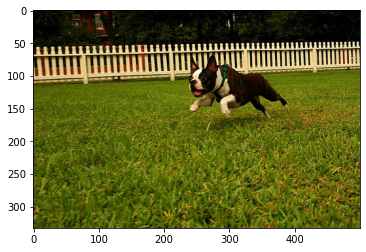

a black and white dog is running through a grassy field


In [ ]:
pic = '1009434119_febe49276a.jpg'
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + pic)
print(df['caption'][df['image'] == pic])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print(predict)